Some plotting functions for the BERT_MLM models.

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
def plot_log_file(metrics_csv, metrics_img):
    df = pd.read_csv(metrics_csv)

    sns.set_theme(style="darkgrid")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 18))  # 2 rows, 1 column
    fontsize = 28

    # Plot Loss
    ax1.plot(df['Epoch'], df['Train Loss'], label='Train Loss', color='tab:red', linewidth=3)
    ax1.plot(df['Epoch'], df['Test Loss'], label='Test Loss', color='tab:orange', linewidth=3)
    ax1.tick_params(axis='x', labelsize=fontsize)
    ax1.set_ylim(0.1, 2.2) 
    ax1.set_ylabel('Loss', fontsize=fontsize)
    ax1.tick_params(axis='y', labelsize=fontsize)
    ax1.legend(loc='upper right', fontsize=fontsize)

    # Plot Accuracy
    ax2.plot(df['Epoch'], df['Train Accuracy'], label='Train Accuracy', color='tab:blue', linewidth=3)
    ax2.plot(df['Epoch'], df['Test Accuracy'], label='Test Accuracy', color='tab:green', linewidth=3)
    ax2.set_xlabel('Epochs', fontsize=fontsize)
    ax2.tick_params(axis='x', labelsize=fontsize)
    ax2.set_ylim(0, 100) 
    ax2.set_ylabel('Accuracy', fontsize=fontsize)
    ax2.tick_params(axis='y', labelsize=fontsize)
    ax2.legend(loc='lower right', fontsize=fontsize)

    plt.tight_layout()
    plt.savefig(metrics_img, format='pdf')
    plt.savefig(metrics_img.replace('.pdf', '.png'), format='png')

In [27]:
def plot_aa_preds_heatmap(preds_csv, preds_img):
    """ Plots heatmap of expected vs predicted amino acid incorrect prediction counts. Expected on x axis. """
    df = pd.read_csv(preds_csv)

    # Create a DataFrame with all possible amino acid combinations
    ALL_AAS = 'ACDEFGHIKLMNPQRSTVWY'
    all_combinations = [(e_aa, p_aa) for e_aa in ALL_AAS for p_aa in ALL_AAS]
    all_df = pd.DataFrame(all_combinations, columns=["Expected", "Predicted"])

    # Split 'expected_aa->predicted_aa' into separate columns
    df[['Expected', 'Predicted']] = df['expected_aa->predicted_aa'].str.split('->', expand=True)

    # Ensure that the epoch columns are numeric and fill any NaNs with 0
    epoch_columns = df.columns[1:-2]  # Assuming epoch columns start at index 1 and go up to the second last column
    df[epoch_columns] = df[epoch_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

    # Sum the counts across all epochs to get the total error count for each expected->predicted pair
    total_count = df[epoch_columns].sum(axis=1)
    df = pd.concat([df, total_count.rename('Total Count')], axis=1)

    # Merge with all possible amino acid combinations so missing pairs get a count of 0
    df = pd.merge(all_df, df[['Expected', 'Predicted', 'Total Count']], how="left", on=["Expected", "Predicted"])
    df["Total Count"].fillna(0, inplace=True)

    # Calculate the total counts for each expected amino acid
    total_counts = df.groupby("Expected")["Total Count"].sum()
    df["Expected Total"] = df["Expected"].map(total_counts)

    # Calculate error percentage
    df["Error Percentage"] = (df["Total Count"] / df["Expected Total"]) * 100
    df["Error Percentage"].fillna(0, inplace=True)

    # Pivot the DataFrame to create a heatmap data structure
    heatmap_data = df.pivot_table(index="Predicted", columns="Expected", values="Error Percentage")

    # Set figure size
    plt.figure(figsize=(16, 9))
    fontsize=16

    # Plot
    cmap = sns.color_palette("rocket_r", as_cmap=True)
    heatmap = sns.heatmap(
        heatmap_data,
        annot=True, fmt=".2f",
        linewidth=.5,
        cmap=cmap, vmin=0, vmax=100,
        annot_kws={"size": 13},
        cbar_kws={'drawedges': False, 'label': 'Prediction Rate (%)'}
    )

    colorbar = heatmap.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=fontsize)  # Set colorbar tick label size
    colorbar.set_label('Prediction Rate (%)', size=fontsize)  # Set colorbar label size

    plt.ylabel('Predicted Amino Acid', fontsize=fontsize)
    plt.xlabel('Expected Amino Acid', fontsize=fontsize)
    plt.xticks(rotation=0, fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)

    plt.tight_layout()
    plt.savefig(preds_img, format='pdf')
    plt.savefig(preds_img.replace('.pdf', '.png'), format='png')

def plot_aa_preds_subtractive_heatmap(preds_csv_1, preds_csv_2, preds_img):
    """
    Plots subtractive heatmap of expected vs predicted amino acid incorrect prediction counts.
    The difference is calculated as the heatmap of model 1 minus model 2.
    """
    def calculate_heatmap_data(preds_csv):
        # Read the CSV file
        df = pd.read_csv(preds_csv)

        # Create a DataFrame with all possible amino acid combinations
        ALL_AAS = 'ACDEFGHIKLMNPQRSTVWY'
        all_combinations = [(e_aa, p_aa) for e_aa in ALL_AAS for p_aa in ALL_AAS]
        all_df = pd.DataFrame(all_combinations, columns=["Expected", "Predicted"])

        # Split 'expected_aa->predicted_aa' into separate columns
        df[['Expected', 'Predicted']] = df['expected_aa->predicted_aa'].str.split('->', expand=True)

        # Ensure that the epoch columns are numeric and fill any NaNs with 0
        epoch_columns = df.columns[1:-2]  # Assuming epoch columns start at index 1 and go up to the second last column
        df[epoch_columns] = df[epoch_columns].apply(pd.to_numeric, errors='coerce').fillna(0)

        # Sum the counts across all epochs to get the total error count for each expected->predicted pair
        total_count = df[epoch_columns].sum(axis=1)
        df = pd.concat([df, total_count.rename('Total Count')], axis=1)

        # Merge with all possible amino acid combinations so missing pairs get a count of 0
        df = pd.merge(all_df, df[['Expected', 'Predicted', 'Total Count']], how="left", on=["Expected", "Predicted"])
        df["Total Count"].fillna(0, inplace=True)

        # Calculate the total counts for each expected amino acid
        total_counts = df.groupby("Expected")["Total Count"].sum()
        df["Expected Total"] = df["Expected"].map(total_counts)

        # Calculate error percentage
        df["Error Percentage"] = (df["Total Count"] / df["Expected Total"]) * 100
        df["Error Percentage"].fillna(0, inplace=True)

        # Pivot the DataFrame to create a heatmap data structure
        heatmap_data = df.pivot_table(index="Predicted", columns="Expected", values="Error Percentage")

        return heatmap_data

    # Calculate heatmap data for both models
    heatmap_data_1 = calculate_heatmap_data(preds_csv_1)
    heatmap_data_2 = calculate_heatmap_data(preds_csv_2)

    # Subtract heatmap 1 from heatmap 2 to create the difference heatmap
    subtractive_heatmap_data = heatmap_data_2 - heatmap_data_1

    # Set figure size
    plt.figure(figsize=(16, 9))
    fontsize=16

    # Plot the subtractive heatmap
    cmap = sns.color_palette("RdBu", as_cmap=True)
    heatmap = sns.heatmap(
        subtractive_heatmap_data,
        annot=True, fmt=".2f",
        linewidth=.5,
        cmap=cmap, vmin=-100, vmax=100,
        annot_kws={"size": 13},
        cbar_kws={'drawedges': False, 'label': 'Difference in Prediction Rate (%)'}
    )

    colorbar = heatmap.collections[0].colorbar
    colorbar.ax.tick_params(labelsize=fontsize)  # Set colorbar tick label size
    colorbar.set_label('Difference in Prediction Rate (%)', size=fontsize)  # Set colorbar label size

    plt.ylabel('Predicted Amino Acid', fontsize=fontsize)
    plt.xlabel('Expected Amino Acid', fontsize=fontsize)
    plt.xticks(rotation=0, fontsize=fontsize-2)
    plt.yticks(fontsize=fontsize-2)

    plt.tight_layout()
    plt.savefig(preds_img, format='pdf')
    plt.savefig(preds_img.replace('.pdf', '.png'), format='png')

## Base model
GPUs: ***1***

Parameters
- n_epochs = ***100***
- batch_size = ***64***
- max_batch = ***-1***
- num_workers = ***64***

Optimizer/Scheduler
- lr = ***1e-5***
- betas = ***(0.9, 0.999)***
- weight_decay = ***0.01***
- d_model = model.bert.embedding_dim: ***320***
- n_warmup_steps = (len(train_data_loader.dataset) / train_data_loader.batch_size) \* 0.1: (277945/64) \* 0.1 = ***434.2890625***

BERT
- max_len = ***280***
- mask_prob = ***0.15***
- embedding_dim = ***320*** 
- dropout = ***0.1***
- n_transformer_layers = ***12***
- n_attn_heads = ***10***

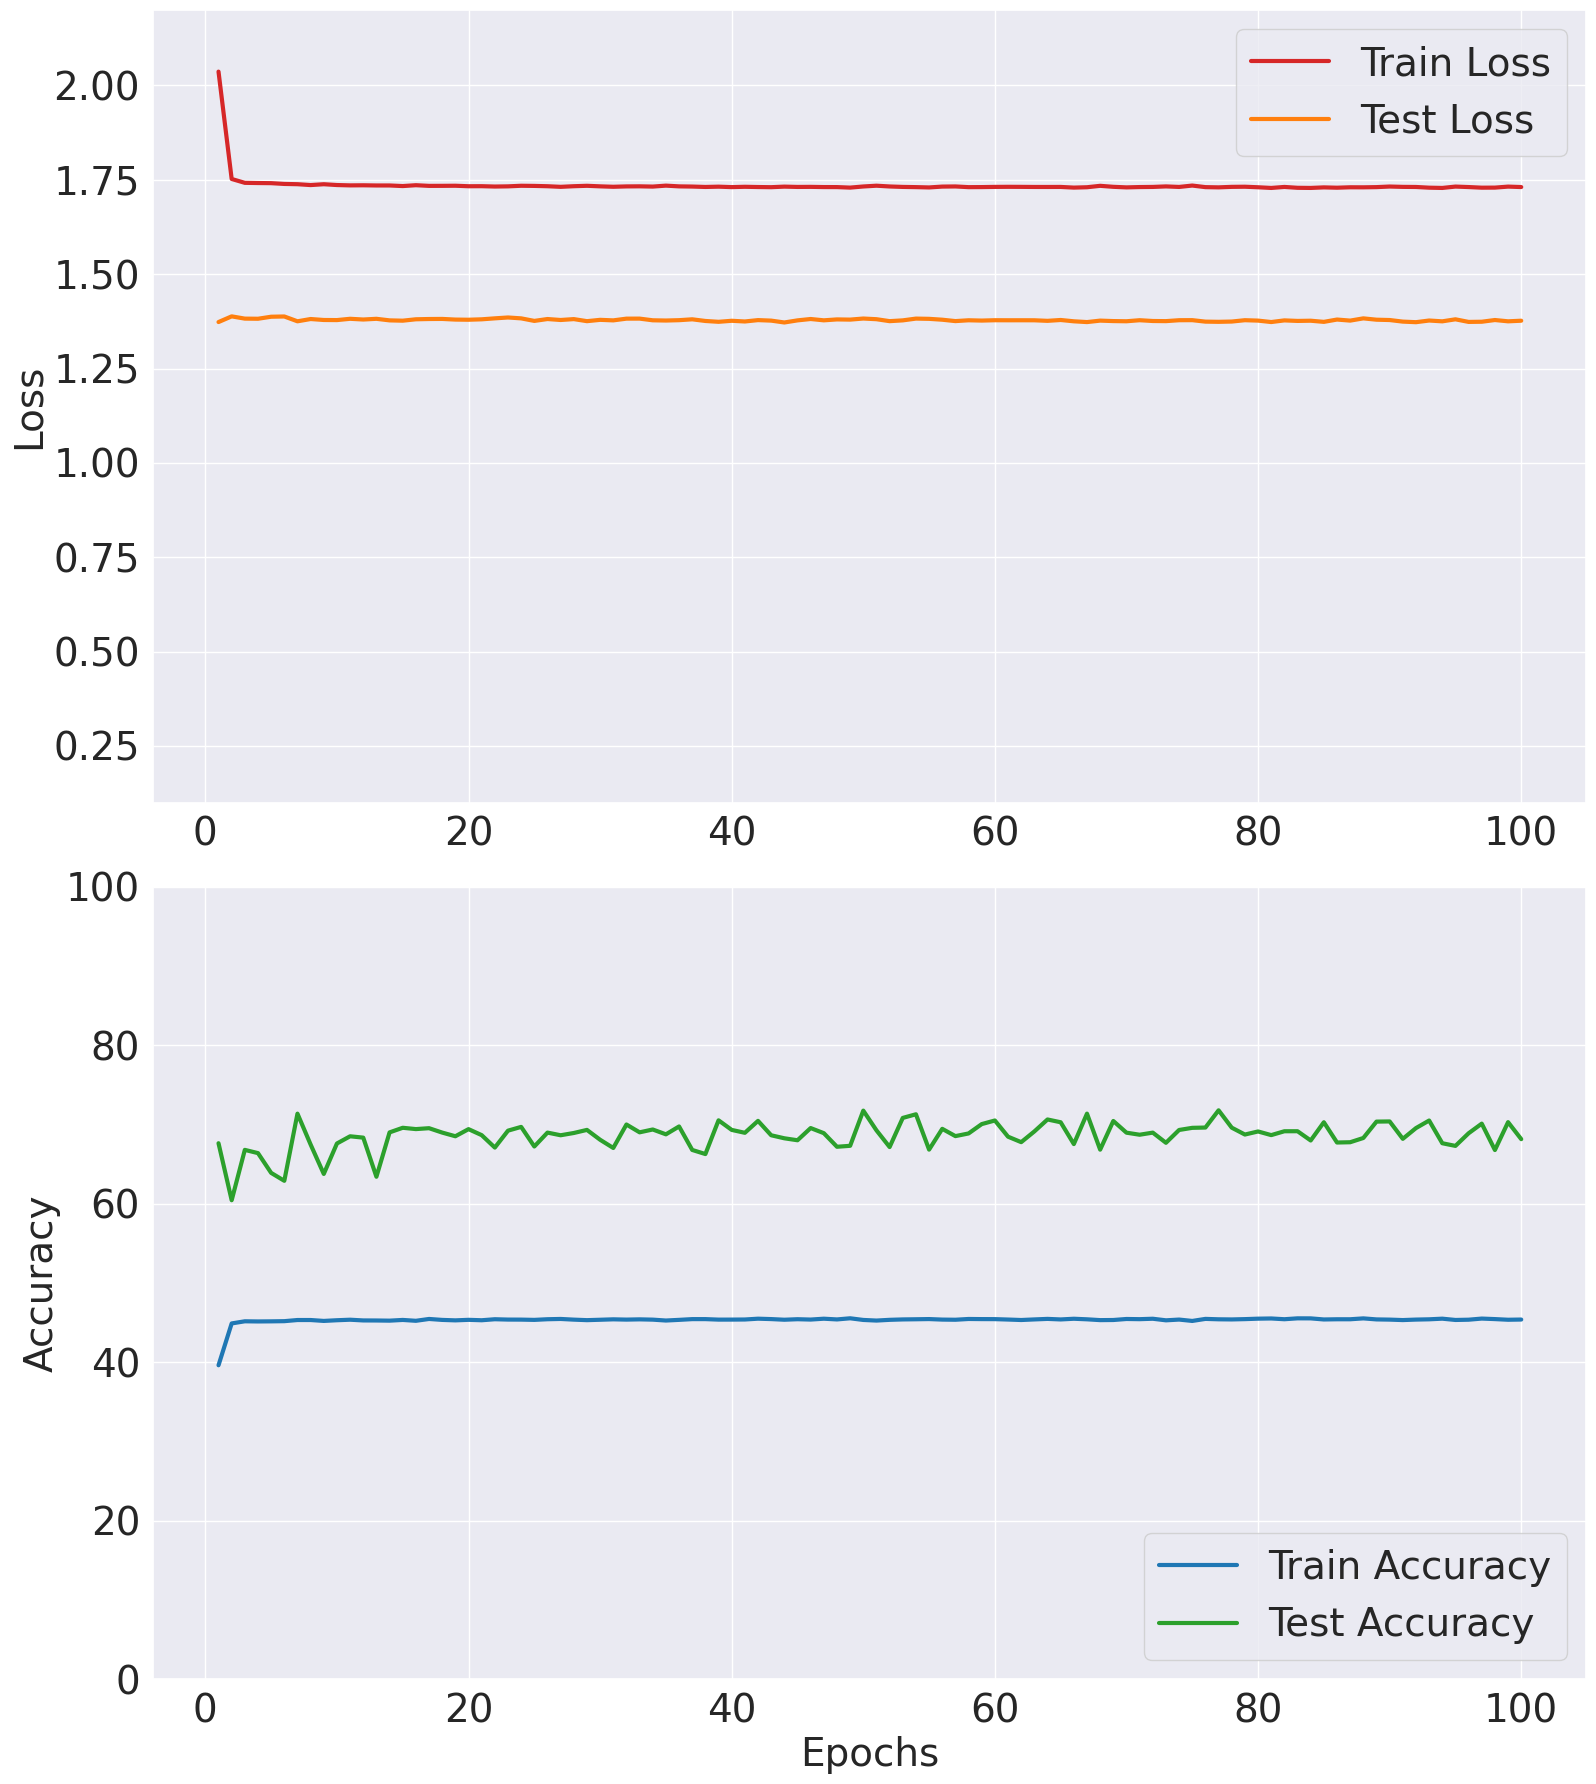

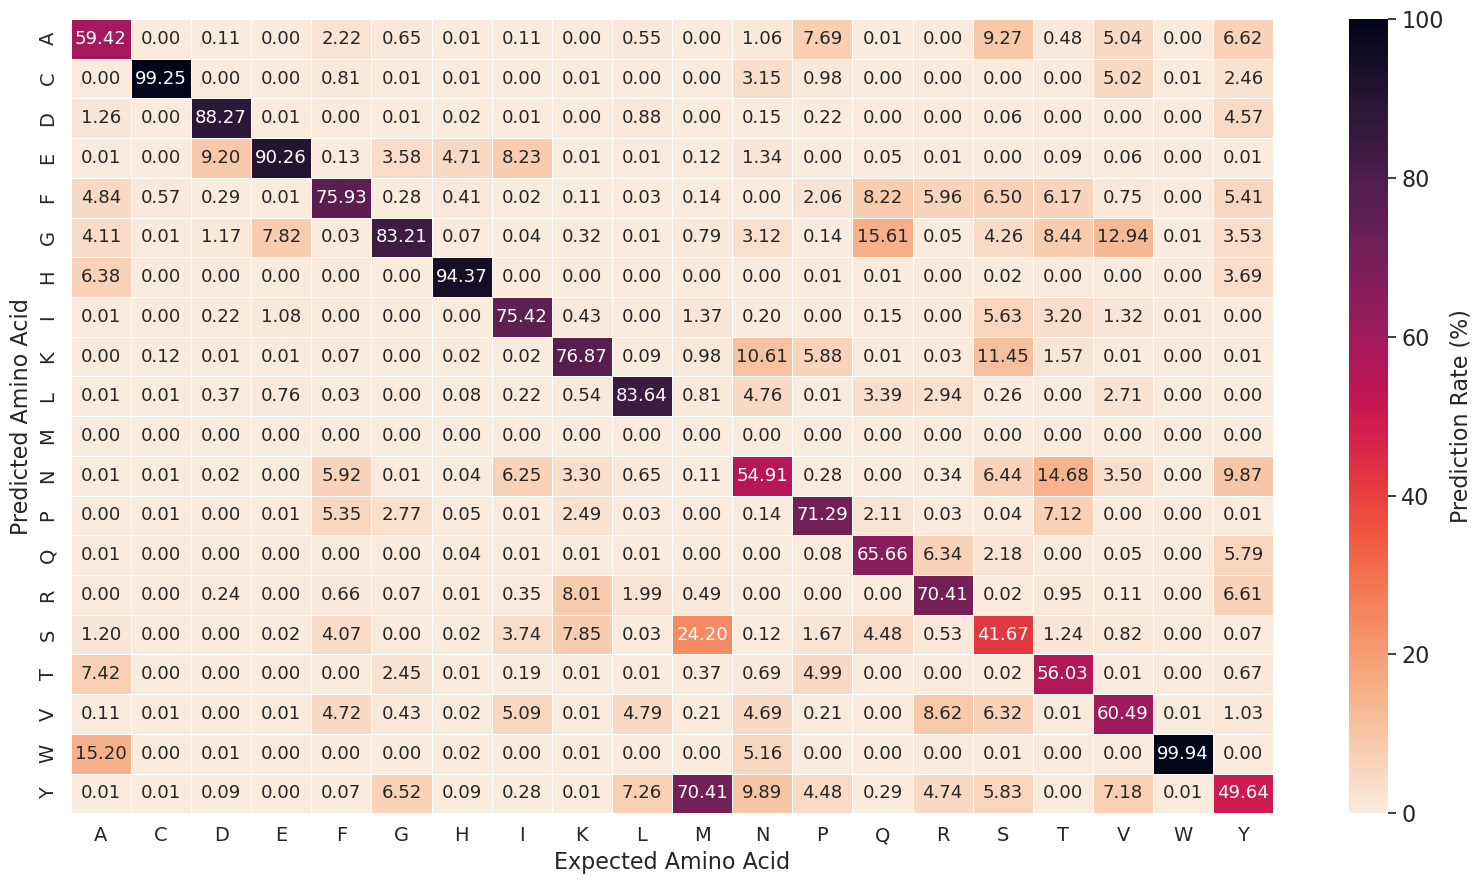

In [33]:
# BERT-MLM
run1 = "../../results/run_results/bert_mlm/bert_mlm-rbd-2024-09-25_20-28/bert_mlm-RBD-train_277945_test_69487"
plot_log_file(run1 + "_metrics.csv", run1 + "_metrics.pdf")
plot_aa_preds_heatmap(run1 + "_predictions.csv", run1 + "_predictions.pdf")

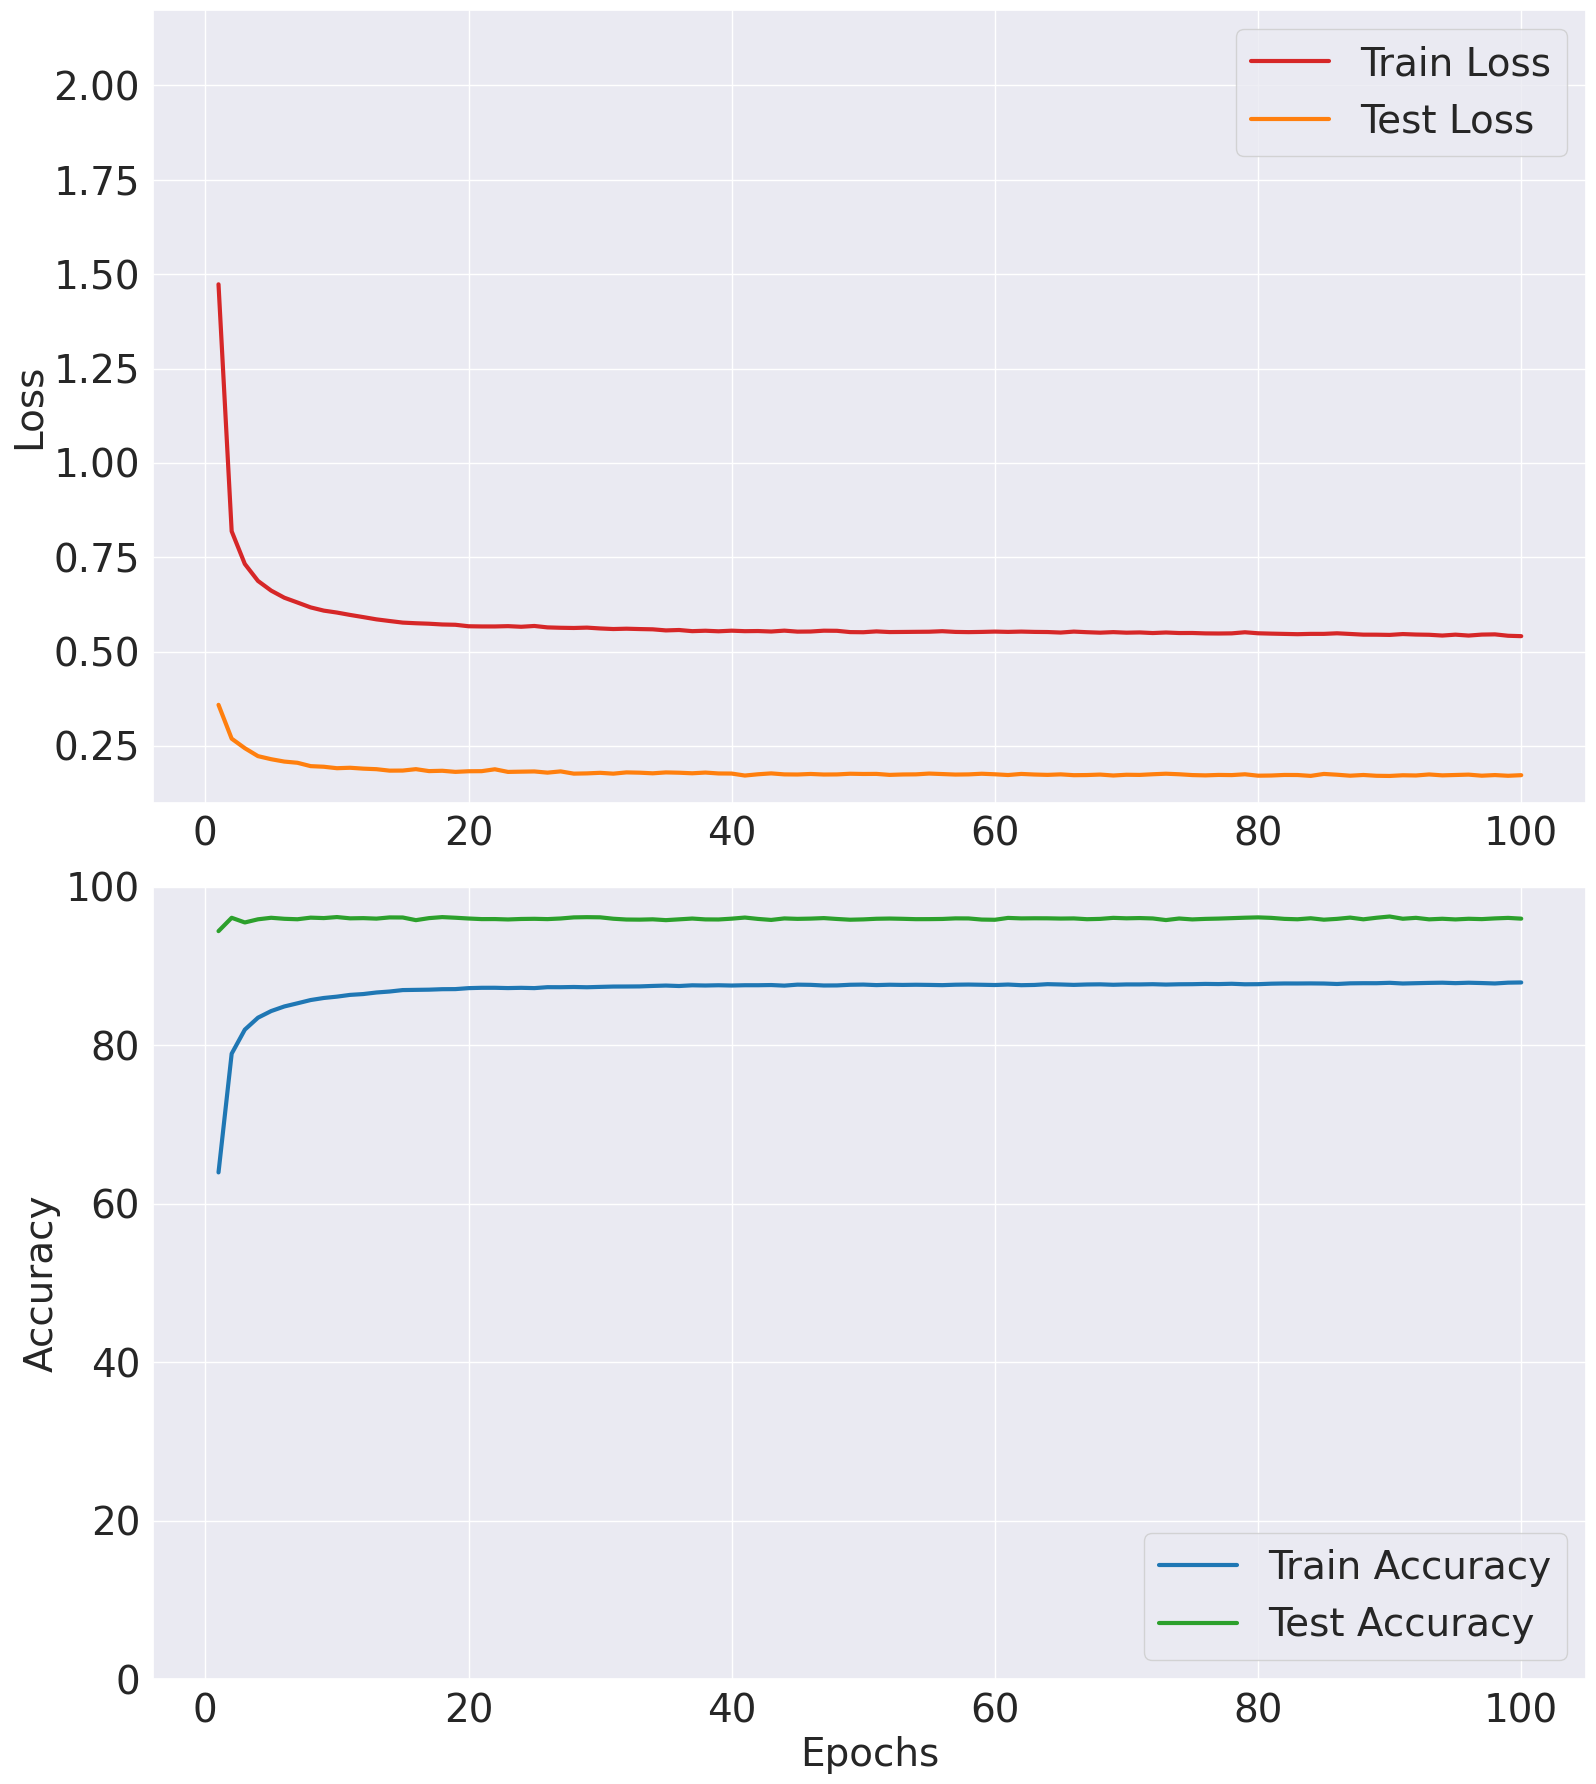

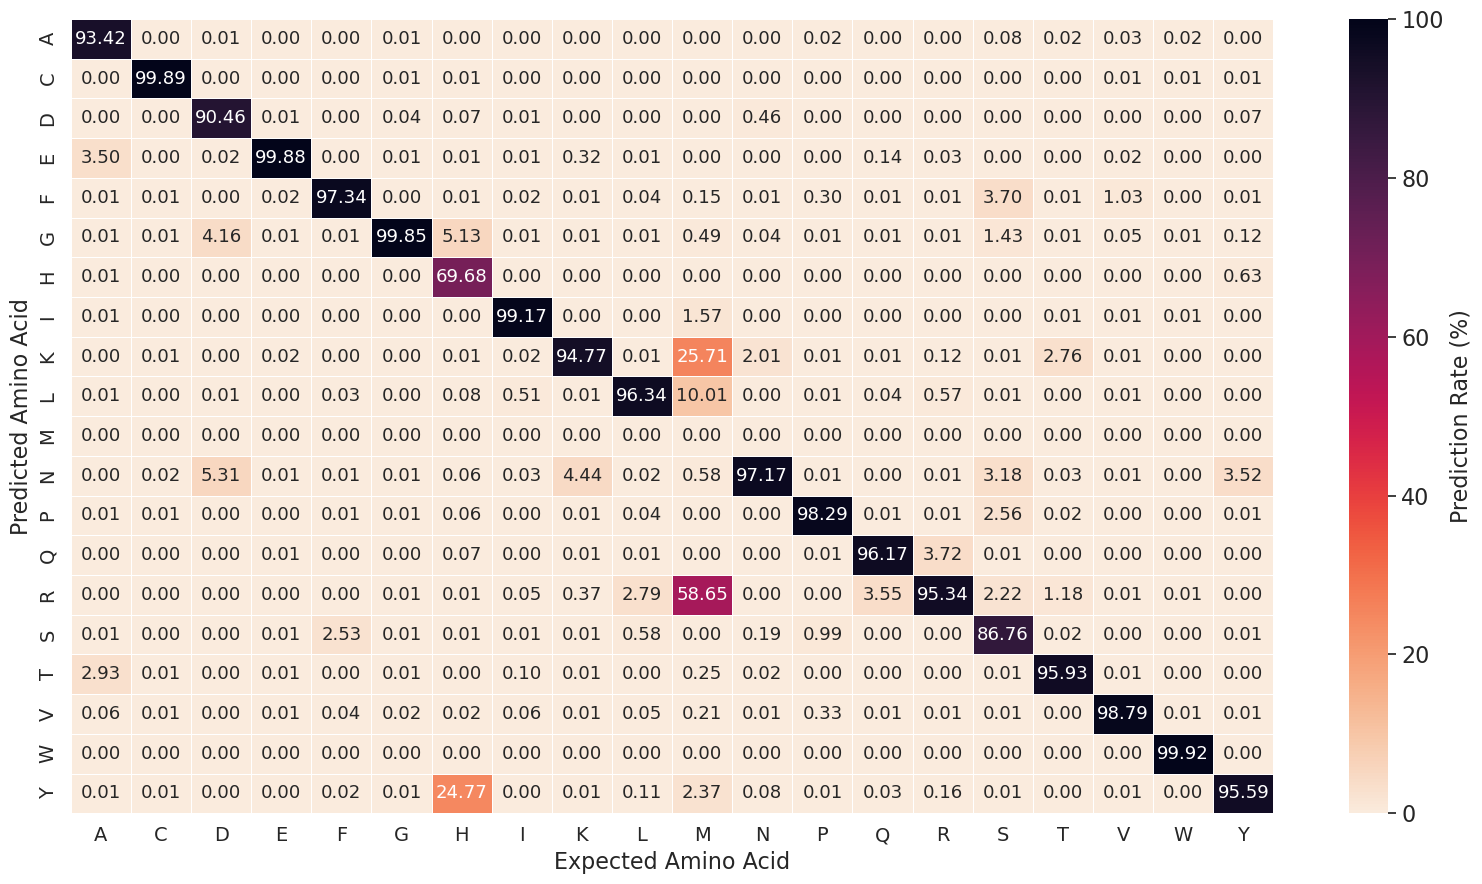

In [29]:
# BERT-MLM INITIALIZED WITH ESM
run2 = "../../results/run_results/bert_mlm-esm_init/bert_mlm-esm_init-rbd-2024-09-25_20-29/bert_mlm-esm_init-RBD-train_277945_test_69487"
plot_log_file(run2 + "_metrics.csv", run2 + "_metrics.pdf")
plot_aa_preds_heatmap(run2 + "_predictions.csv", run2 + "_predictions.pdf")

### Comparison - Subtractive Heatmap

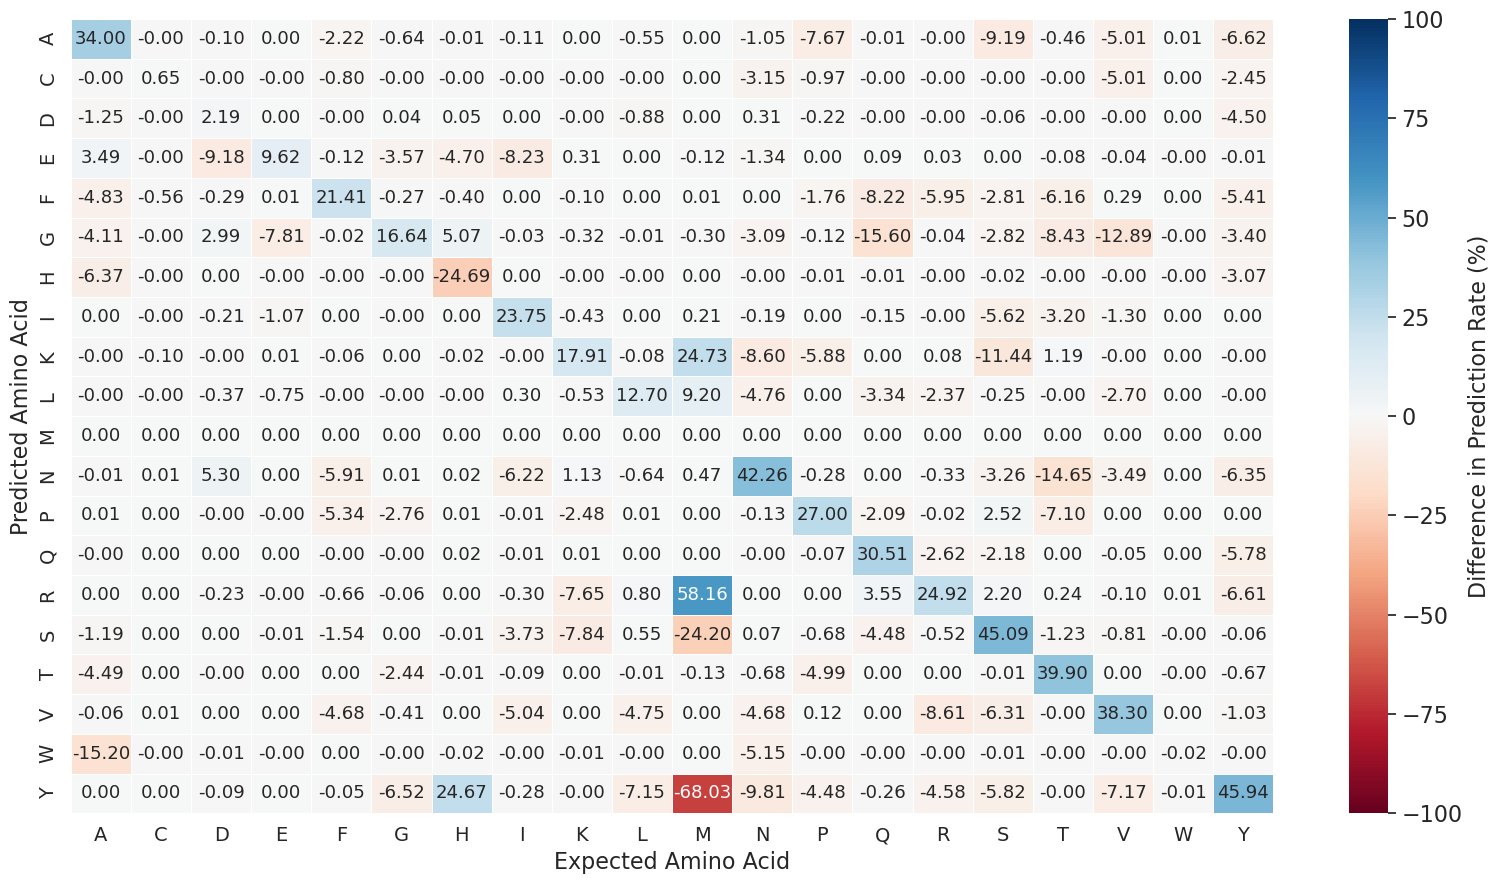

In [35]:
# The "better" one should be preds_csv_2, we want to show the improvement in V2 vs V1
preds_img = f"../../results/plots/model_comparisons/{run1.split('/')[4]}.vs.{run2.split('/')[4]}.pdf"
plot_aa_preds_subtractive_heatmap(
    preds_csv_1=run1 + "_predictions.csv", 
    preds_csv_2=run2 + "_predictions.csv", 
    preds_img=preds_img
)

Runtime difference:
- ***BERT-MLM***: Model took 12:47:55.739316 (D day(s), H:MM:SS.microseconds).
- ***BERT-MLM INITIALIZED WITH ESM***: Model took 13:13:40.750587 (D day(s), H:MM:SS.microseconds).

---
## DDP base model

GPUs: ***4***

Parameters
- n_epochs = ***100***
- batch_size = ***64***
- max_batch = ***-1***
- num_workers = ***64***

Optimizer/Scheduler
- lr = ***1e-5***
- betas = ***(0.9, 0.999)***
- weight_decay = ***0.01***
- d_model = model.bert.embedding_dim: ***320***
- n_warmup_steps = (len(train_data_loader.dataset) / (train_data_loader.batch_size \* 4)) \* 0.1: (277945/(64*4)) * 0.1 ≈ ***108.57***
BERT
- max_len = ***280***
- mask_prob = ***0.15***
- embedding_dim = ***320*** 
- dropout = ***0.1***
- n_transformer_layers = ***12***
- n_attn_heads = ***10***

*NOTE: These are per GPU numbers. Really the effective `batch_size` is ***(64 \* 4)***, and the adjusted `lr` is ***((1e-5) \* 4)***. `n_warmup_steps` is already adjusted based on the global batch size here though, and the learning rate gets adjusted in the optimizer call.



In [ ]:
# DDP - BERT-MLM
run3 = "../../results/"
plot_log_file(run3 + "_metrics.csv", run3 + "_metrics.pdf")
plot_aa_preds_heatmap(run3 + "_predictions.csv", run3 + "_predictions.pdf")

In [ ]:
# DDP - BERT-MLM INITIALIZED WITH ESM
run4 = "../../results/"
plot_log_file(run4 + "_metrics.csv", run4 + "_metrics.pdf")
plot_aa_preds_heatmap(run4 + "_predictions.csv", run4 + "_predictions.pdf")

### Comparison - Subtractive Heatmap

In [ ]:
# The "better" one should be preds_csv_2, we want to show the improvement in V2 vs V1
preds_img = f"../../results/plots/model_comparisons/{run3.split('/')[4]}.vs.{run4.split('/')[4]}.pdf"
plot_aa_preds_subtractive_heatmap(
    preds_csv_1=run4 + "_predictions.csv", 
    preds_csv_2=run4 + "_predictions.csv", 
    preds_img=preds_img
)

Runtime difference:
- ***DDP BERT-MLM***: Model took `<INSERT>` (D day(s), H:MM:SS.microseconds).
- ***DDP BERT-MLM INITIALIZED WITH ESM***: Model took `<INSERT>` (D day(s), H:MM:SS.microseconds).